In [1]:
import matplotlib.pyplot as plt
import kornia
import numpy as np
import scipy
import cv2
from skimage.transform import warp, ProjectiveTransform

In [2]:
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

optimal [[ 1.01928835e+00  5.34347776e-02  1.42480330e+03]
 [-5.38174307e-02  1.01941844e+00  1.24676818e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
best [[ 1.01928835e+00  5.34347776e-02  1.42480330e+03]
 [-5.38174307e-02  1.01941844e+00  1.24676818e+02]]


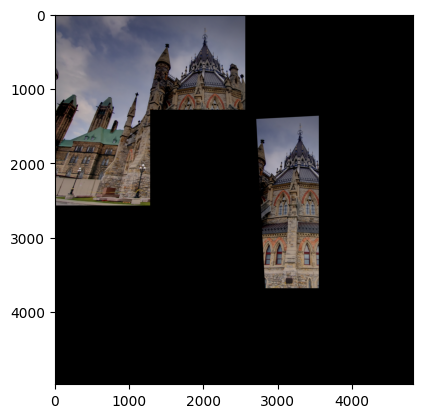

In [66]:
#def ransac(imag1,image2,threshold,iterations):
#code for detecting common features between images and stitching them together

im1 = plt.imread('/cs/home/curtlac/Downloads/parliament-right.jpg')
im2 = plt.imread('/cs/home/curtlac/Downloads/parliament-left.jpg')
image1 = plt.imread('/cs/home/curtlac/Downloads/parliament-right.jpg')
image2 = plt.imread('/cs/home/curtlac/Downloads/parliament-left.jpg')

grey1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
grey2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

sift1 = cv2.SIFT_create()
kp1,des1 = sift1.detectAndCompute(grey1,None)
im1 = cv2.drawKeypoints(grey1,kp1,im1)
sift2 = cv2.SIFT_create()
kp2,des2 = sift2.detectAndCompute(grey2,None)
im2 = cv2.drawKeypoints(grey2,kp2,im2)
im2_resized = cv2.resize(im2, (im1.shape[1],im1.shape[0]))

#plt.imshow(im1)

features = scipy.spatial.distance.cdist(des1,des2,'sqeuclidean')
threshold = 320
thresh_ind = np.argwhere(features < threshold)
thresh_dist = features[thresh_ind[:, 0], thresh_ind[:, 1]]
thresh_features = np.column_stack([thresh_ind, thresh_ind + [0, im1.shape[1]], thresh_dist])

dnt,ax = plt.subplots()
#plot_inlier_matches(ax,im1,im2_resized,thresh_features)

best_affine = None
best_inliers = 0
iterations = 150

kp1_np = np.float32([kp.pt for kp in kp1]).reshape(-1,1,2)
kp2_np = np.float32([kp.pt for kp in kp2]).reshape(-1,1,2)

for i in range(iterations):

    #we select the minimum amount of keypoints needed to estimate an affine transformation, which is 3 in this case.
    indices = np.random.choice(len(thresh_features),4,replace=False)
    matches = [thresh_features[j] for j in indices]

    
    src_indices = [int(match[0]) for match in matches]
    dst_indices = [int(match[1]) for match in matches]

   
    src = kp1_np[src_indices].reshape(-1, 1, 2)
    dst = kp2_np[dst_indices].reshape(-1, 1, 2)
    
    
    affine, i = cv2.estimateAffine2D(src, dst)
    inliers = sum(np.linalg.norm(cv2.transform(np.float32([kp1_np[src_idx]]), affine) - np.float32([kp2_np[dst_idx]])) < threshold
                  for src_idx, dst_idx in zip(src_indices, dst_indices))
    
    if(inliers > best_inliers):
        best_inliers = inliers
        best_affine = affine








optimal_affine = np.vstack([best_affine, [0, 0, 1]])
opt_tran_sci = ProjectiveTransform(matrix=optimal_affine)
output = warp(image1, opt_tran_sci.inverse)
output = output*255

mosaic_image = np.zeros((max(image2.shape[0], output.shape[0] + image2.shape[0]),
                         max(image2.shape[1], output.shape[1] + image2.shape[1]), 3), dtype=np.uint8)

mosaic_image[:image2.shape[0], :image2.shape[1], :] = image2

mosaic_row_start = (mosaic_image.shape[0] - output.shape[0]) // 2
mosaic_row_end = mosaic_row_start + output.shape[0]
mosaic_col_start = (mosaic_image.shape[1] - output.shape[1]) // 2
mosaic_col_end = mosaic_col_start + output.shape[1]
mosaic_image[mosaic_row_start:mosaic_row_end, mosaic_col_start:mosaic_col_end] = output



#mosaic_image = cv2.cvtColor(mosaic_image, cv2.COLOR_BGR2RGB)
plt.imshow(mosaic_image)
print("optimal",optimal_affine)
print("best",best_affine)
